In [ ]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "10_mlops/10b_explain.ipynb"
_nb_title = "Explain predictions"

_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))

# Explainable AI  

このノートブックでは、XAIの技術を使用して、画像分類モデルが予測を行う際に注目している特徴量を可視化します。

## シグネチャの作成

第5章でモデルをトレーニングしたときに作成されたチェックポイントから始めましょう。
モデルを再トレーニングする必要はありません。

In [ ]:
import tensorflow as tf
import os, shutil

from datetime import datetime
from google.cloud import aiplatform

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT +  "-flowers-xai"  # defaults to PROJECT
REGION = "us-central1"  # Replace with your REGION
OUTDIR = f"gs://{BUCKET}/flowers/model_{TIMESTAMP}"

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["OUTDIR"] = OUTDIR
os.environ["TIMESTAMP"] = TIMESTAMP
print(f"Project: {PROJECT}")

MODEL_LOCATION='export/flowers_model3'  # will be created

In [ ]:
%%bash
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
   echo -e "Bucket gs://${BUCKET} already exists."
    
else
   echo "Creating a new GCS bucket."
   echo ${BUCKET}
   gsutil mb -l ${REGION} gs://${BUCKET}
fi

In [4]:
# load from checkpoint and export a model that has desired signature
CHECK_POINT_DIR='gs://practical-ml-vision-book/flowers_5_trained/chkpts'
model = tf.keras.models.load_model(CHECK_POINT_DIR)

2022-08-15 20:17:01.420725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 20:17:01.430664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 20:17:01.431328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 20:17:01.432912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
IMG_HEIGHT = 345
IMG_WIDTH = 345
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

def preprocess(filename):
    img_bytes = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)

@tf.function(input_signature=[tf.TensorSpec([None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], dtype=tf.float32)])
def xai_model(input_images):
    batch_pred = model(input_images) # same as model.predict()
    top_prob = tf.math.reduce_max(batch_pred, axis=[1])
    pred_label_index = tf.math.argmax(batch_pred, axis=1)
    pred_label = tf.gather(tf.convert_to_tensor(CLASS_NAMES), pred_label_index)
    return {
        'probability': top_prob,
        'flower_type_int': pred_label_index,
        'flower_type_str': pred_label
    }

@tf.function(input_signature=[tf.TensorSpec([None,], dtype=tf.string)])
def xai_preprocess(filenames):
    input_images = tf.map_fn(
        preprocess,
        filenames,
        fn_output_signature=tf.float32
    )
    return {
        # match the signature of xai_model
        'input_images': input_images
    }

@tf.function(input_signature=[tf.TensorSpec([None,], dtype=tf.string)])
def predict_filename(filenames):
    preproc_output = xai_preprocess(filenames)
    # return xai_model(preproc_output['input_images'])
    return xai_model(**preproc_output)

shutil.rmtree('export', ignore_errors=True)
os.mkdir('export')
model.save(MODEL_LOCATION,
          signatures={
              'serving_default': predict_filename,
              'xai_preprocess': xai_preprocess, # should be exactly what's supplied to model
              'xai_model': xai_model # call the model
          })

INFO:tensorflow:Assets written to: export/flowers_model3/assets


In [6]:
!saved_model_cli show --dir {MODEL_LOCATION} --tag serve --signature serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['filenames'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_filenames:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['flower_type_int'] tensor_info:
      dtype: DT_INT64
      shape: (-1)
      name: StatefulPartitionedCall:0
  outputs['flower_type_str'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: StatefulPartitionedCall:1
  outputs['probability'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: StatefulPartitionedCall:2
Method name is: tensorflow/serving/predict


In [7]:
!saved_model_cli show --dir {MODEL_LOCATION} --tag serve --signature xai_model

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_images'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 345, 345, 3)
      name: xai_model_input_images:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['flower_type_int'] tensor_info:
      dtype: DT_INT64
      shape: (-1)
      name: StatefulPartitionedCall_1:0
  outputs['flower_type_str'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: StatefulPartitionedCall_1:1
  outputs['probability'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: StatefulPartitionedCall_1:2
Method name is: tensorflow/serving/predict


In [8]:
!saved_model_cli show --dir {MODEL_LOCATION} --tag serve --signature xai_preprocess

The given SavedModel SignatureDef contains the following input(s):
  inputs['filenames'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: xai_preprocess_filenames:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['input_images'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 345, 345, 3)
      name: StatefulPartitionedCall_2:0
Method name is: tensorflow/serving/predict


## 追加のシグネチャのテスト

In [9]:
serving_fn = tf.keras.models.load_model(MODEL_LOCATION).signatures['serving_default']
filenames = [
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/9299302012_958c70564c_n.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8733586143_3139db6e9e_n.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713397358_0505cc0176_n.jpg'
]
pred = serving_fn(tf.convert_to_tensor(filenames))
print(pred)

2022-08-15 20:17:24.731677: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


{'flower_type_int': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 0, 4, 4])>, 'probability': <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.398337 , 0.9999609, 0.9947188, 0.9590066, 0.9417732],
      dtype=float32)>, 'flower_type_str': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'dandelion', b'dandelion', b'daisy', b'tulips', b'tulips'],
      dtype=object)>}


In [10]:
xai_preprocess = tf.keras.models.load_model(MODEL_LOCATION).signatures['xai_preprocess']
filenames = [
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
]
pred = xai_preprocess(tf.convert_to_tensor(filenames))
print(pred)

{'input_images': <tf.Tensor: shape=(1, 345, 345, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0.

In [11]:
!gsutil cp -r {MODEL_LOCATION} {OUTDIR}

Copying file://export/flowers_model3/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://export/flowers_model3/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://export/flowers_model3/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://export/flowers_model3/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [4 files][ 10.9 MiB/ 10.9 MiB]                                                
Operation completed over 4 objects/10.9 MiB.                                     


## XAIメタデータを作成する  

Python APIを使用して、XAIの対象となる入力と出力を指定するメタデータを作成します。

In [13]:
input_name = "input_images"
output_name = "probability"

INPUT_METADATA = {"input_tensor_name": input_name, "modality": "image"}
OUTPUT_METADATA = {"output_tensor_name": output_name}

input_metadata = aiplatform.explain.ExplanationMetadata.InputMetadata(
    INPUT_METADATA
)
output_metadata = aiplatform.explain.ExplanationMetadata.OutputMetadata(
    OUTPUT_METADATA
)

metadata = aiplatform.explain.ExplanationMetadata(
    inputs={"image": input_metadata}, outputs={"class": output_metadata}
)

また、使用する手法に合わせたメタデータを作成します。ここでは統合勾配(Integrated Gradient)用のパラメータを指定します。

In [14]:
parameters = aiplatform.explain.ExplanationParameters(
    {"integrated_gradients_attribution": {"step_count": 50}}
)

## 統合勾配(Integrated Gradient: IG)モデルをVertex AIにデプロイする  

上記のモデルをVertex AIにデプロイして、統合勾配の説明を取得します。

In [15]:
MODEL_NAME='flowers_ig'

aiplatform.init(project=PROJECT, staging_bucket=BUCKET)

ig_model = aiplatform.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=OUTDIR,
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest",
    explanation_parameters=parameters,
    explanation_metadata=metadata,
    sync=True,
)

Creating Model
Create Model backing LRO: projects/849204435784/locations/us-central1/models/9130674410540236800/operations/952731567111798784
Model created. Resource name: projects/849204435784/locations/us-central1/models/9130674410540236800@1
To use this Model in another session:
model = aiplatform.Model('projects/849204435784/locations/us-central1/models/9130674410540236800@1')


In [16]:
ig_endpoint = ig_model.deploy(
    deployed_model_display_name=MODEL_NAME,
    traffic_split={"0": 100},
    machine_type="n1-standard-8",
    min_replica_count=1,
    max_replica_count=1,
)

Creating Endpoint
Create Endpoint backing LRO: projects/849204435784/locations/us-central1/endpoints/4057382624446906368/operations/7113655857354637312
Endpoint created. Resource name: projects/849204435784/locations/us-central1/endpoints/4057382624446906368
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/849204435784/locations/us-central1/endpoints/4057382624446906368')
Deploying model to Endpoint : projects/849204435784/locations/us-central1/endpoints/4057382624446906368
Deploy Endpoint model backing LRO: projects/849204435784/locations/us-central1/endpoints/4057382624446906368/operations/307590920490975232
Endpoint model deployed. Resource name: projects/849204435784/locations/us-central1/endpoints/4057382624446906368


## 統合勾配 (Integrated Gradient)の説明を取得する

In [17]:
instances = [
    {"filenames": "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg"},
    {"filenames": "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg"},
    {"filenames": "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/9299302012_958c70564c_n.jpg"},
    {"filenames": "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8733586143_3139db6e9e_n.jpg"},
    {"filenames": "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713397358_0505cc0176_n.jpg"}
]

以下のコマンドで、説明を取得することができます。BadGateway Error が出た場合、エンドポイントの環境の立ち上げに時間がかかっていか、負荷が高くなっている可能性があります。<br>
少し待ってから再度実行してください。

In [19]:
response = ig_endpoint.explain(instances)

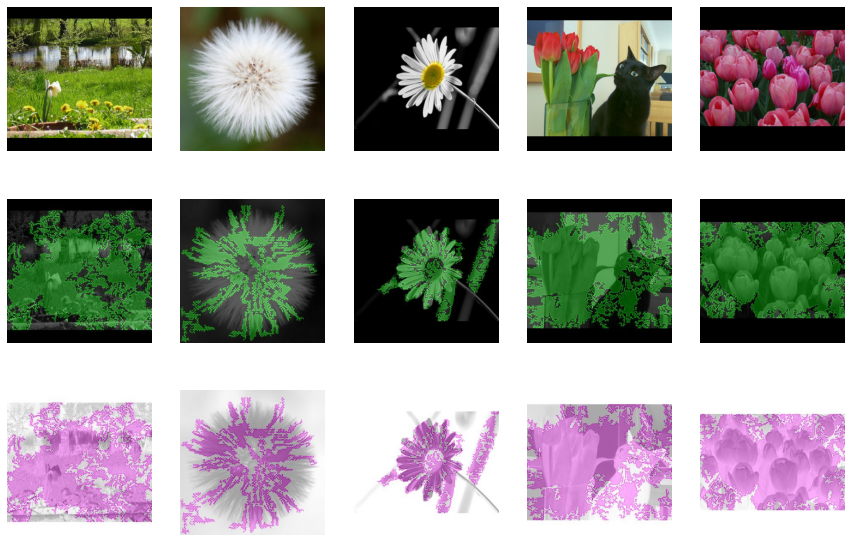

In [20]:
import base64
import matplotlib.pyplot as plt

def plot_attributions(instances, response):
    input_images = []
    for instance in instances:
        img_bytes = tf.io.read_file(instance['filenames'])
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
        input_images.append(img.numpy())

    explain_images = []
    for expln in response.explanations:
        attribution = expln.attributions[0]
        b64bytes = attribution.feature_attributions["image"]["b64_jpeg"]
        img_bytes = base64.b64decode(b64bytes)
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        explain_images.append(img.numpy())


    f, ax = plt.subplots(3, 5, figsize=(15,10))
    for idx in range(len(input_images)):
        ax[0, idx].imshow(input_images[idx])
        ax[1, idx].imshow(explain_images[idx])
        ax[2, idx].imshow(1-explain_images[idx])
        ax[0, idx].axis('off')
        ax[1, idx].axis('off')
        ax[2, idx].axis('off')
        
plot_attributions(instances, response)

## XRAIのデプロイ、説明の取得  

XRAI用のメタデータを指定すれば、IGではなくXRAIからの説明を取得可能です。

In [21]:
parameters = aiplatform.explain.ExplanationParameters(
    {"xrai_attribution": {"step_count": 50}}
)

In [22]:
MODEL_NAME='flowers_xrai'

aiplatform.init(project=PROJECT, staging_bucket=BUCKET)

xrai_model = aiplatform.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=OUTDIR,
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest",
    explanation_parameters=parameters,
    explanation_metadata=metadata,
    sync=True,
)

xrai_endpoint = xrai_model.deploy(
    deployed_model_display_name=MODEL_NAME,
    traffic_split={"0": 100},
    machine_type="n1-standard-8",
    min_replica_count=1,
    max_replica_count=1,
)

Creating Model
Create Model backing LRO: projects/849204435784/locations/us-central1/models/5156247739385774080/operations/1611383012614733824
Model created. Resource name: projects/849204435784/locations/us-central1/models/5156247739385774080@1
To use this Model in another session:
model = aiplatform.Model('projects/849204435784/locations/us-central1/models/5156247739385774080@1')
Creating Endpoint
Create Endpoint backing LRO: projects/849204435784/locations/us-central1/endpoints/7471111141993742336/operations/9161667787901370368
Endpoint created. Resource name: projects/849204435784/locations/us-central1/endpoints/7471111141993742336
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/849204435784/locations/us-central1/endpoints/7471111141993742336')
Deploying model to Endpoint : projects/849204435784/locations/us-central1/endpoints/7471111141993742336
Deploy Endpoint model backing LRO: projects/849204435784/locations/us-central1/endpoints/74711111419937

以下のコマンドで、説明を取得することができます。BadGateway Error が出た場合、エンドポイントの環境の立ち上げに時間がかかっていか、負荷が高くなっている可能性があります。<br>
少し待ってから再度実行してください。

In [25]:
response = xrai_endpoint.explain(instances)

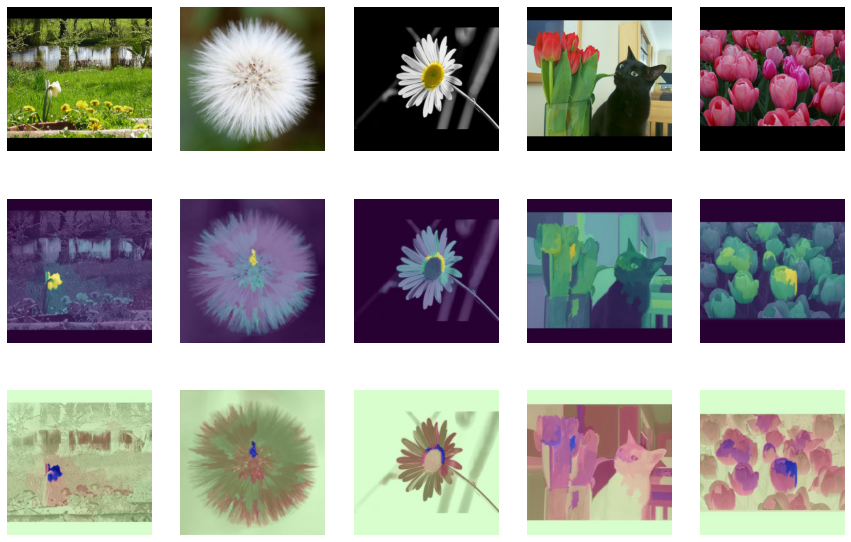

In [26]:
plot_attributions(instances, response)

結果として得られる説明は、IGと比べてなめらかで直感的に見えます。
しかし、X線のような画像でピクセル単位の説明がよりふさわしい場合、統合グラデーションの方が適しているかもしれません。

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.